In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import scipy.linalg as la
import pylab as pl
from scipy.spatial.distance import cdist
import numpy as np
import scipy.io
import os
from itertools import product
import time
from copy import deepcopy
from scipy.linalg import eigh

In [12]:
class krr:
    def __init__(self, kernel='linear', kernelparameter=None, regularization=1.0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization
        self.alpha = None
        self.Xtrain = None

    def _linear_kernel(self, X, Y):
        return np.dot(X, Y.T)

    def _polynomial_kernel(self, X, Y, d):
        return (np.dot(X, Y.T) + 1) ** d

    def _gaussian_kernel(self, X, Y, s):
        if s is None:
            raise ValueError("Kernel width 's' must be specified for Gaussian kernel.")
        K = np.zeros((X.shape[0], Y.shape[0]))
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.exp(-np.linalg.norm(x - y) ** 2 / (2 * s ** 2))
        return K

    def _compute_kernel(self, X, Y):
        if self.kernel == 'linear':
            return self._linear_kernel(X, Y)
        elif self.kernel == 'polynomial':
            d = self.kernelparameter if self.kernelparameter is not None else 2
            return self._polynomial_kernel(X, Y, d)
        elif self.kernel == 'gaussian':
            s = self.kernelparameter if self.kernelparameter is not None else 1.0
            return self._gaussian_kernel(X, Y, s)
        else:
            raise ValueError("Unknown kernel type.")

    def fit(self, Xtrain, ytrain):
        self.Xtrain = Xtrain
        K = self._compute_kernel(Xtrain, Xtrain)

        # Regularization and alpha calculation
        n = K.shape[0]
        I = np.eye(n)
        if self.regularization == 0:
            # Leave-one-out cross-validation to choose regularization parameter
            eigenvalues = eigh(K, eigvals_only=True)
            C_candidates = np.logspace(np.log10(eigenvalues.mean() / 10), np.log10(eigenvalues.mean() * 10), num=10)
            best_C = self._leave_one_out_cross_validation(K, ytrain, C_candidates)
            C = best_C
        else:
            C = self.regularization

        self.alpha = np.linalg.solve(K + C * I, ytrain)

    def _leave_one_out_cross_validation(self, K, y, C_candidates):
        n = K.shape[0]
        I = np.eye(n)
        best_C = C_candidates[0]
        best_error = float('inf')

        for C in C_candidates:
            alpha = np.linalg.solve(K + C * I, y)
            y_pred = K.dot(alpha)
            errors = (y - y_pred) / (1 - np.diag(K) * np.linalg.solve(K + C * I, np.ones(n)))
            error = np.mean(errors ** 2)

            if error < best_error:
                best_error = error
                best_C = C

        return best_C

    def predict(self, Xtest):
        Ktest = self._compute_kernel(Xtest, self.Xtrain)
        return Ktest.dot(self.alpha)
    
    def transform_coulomb_matrices(coulomb_matrices):
        eigenvalue_vectors = []
        for M in coulomb_matrices:
            eigenvalues = np.linalg.eigvalsh(M)  # Compute eigenvalues
            sorted_eigenvalues = np.sort(np.abs(eigenvalues))[::-1]  # Sort by absolute value in descending order
            eigenvalue_vectors.append(sorted_eigenvalues)
        return np.array(eigenvalue_vectors)

In [3]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def cv(X: np.ndarray, y: np.ndarray, method, parameters: dict,
       loss_function=mean_absolute_error, nfolds: int = 10, nrepetitions: int = 5):
    n = X.shape[0]

    # Generate all parameter combinations from the dictionary
    param_combinations = list(product(*parameters.values()))
    param_names = list(parameters.keys())

    best_loss = float('inf')
    best_params = None
    best_method = None

    total_iterations = len(param_combinations) * nrepetitions
    iteration = 0
    start_time = time.time()

    # Iterate over all parameter combinations
    for pc in param_combinations:
        param_dict = dict(zip(param_names, pc))
        avg_loss = 0

        # Repeat cross-validation for the specified number of repetitions
        for _ in range(nrepetitions):
            indices = np.arange(n)
            np.random.shuffle(indices)
            fold_sizes = (n // nfolds) * np.ones(nfolds, dtype=int)
            fold_sizes[:n % nfolds] += 1
            current = 0

            # Perform n-fold cross-validation
            for fold_size in fold_sizes:
                # Define start and stop for validation fold
                start, stop = current, current + fold_size

                # Define indices for validation set
                validation_ind = indices[start:stop]
                # Define indices for training set
                train_ind = np.concatenate([indices[:start], indices[stop:]])

                X_train, y_train = X[train_ind], y[train_ind]
                X_val, y_val = X[validation_ind], y[validation_ind]

                # Instantiate and train the method with the current parameter combination
                method_instance = method(**param_dict)
                method_instance.fit(X_train, y_train)

                # Predict on the validation set
                y_pred = method_instance.predict(X_val)

                # Calculate the loss for the current fold
                fold_loss = loss_function(y_val, y_pred)
                avg_loss += fold_loss

                current = stop

        # Average the loss over all repetitions and folds
        avg_loss /= (nrepetitions * nfolds)

        # Update the best method if the current one has a lower loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = param_dict
            best_method = deepcopy(method_instance)

        iteration += 1
        elapsed_time = time.time() - start_time
        remaining_time = (total_iterations - iteration) * (elapsed_time / iteration)
        print(
            f'Iteration {iteration}/{total_iterations}, elapsed time: {elapsed_time:.2f}s, estimated remaining time: {remaining_time:.2f}s')

    # Special case for a single parameter combination
    if len(param_combinations) == 1:
        best_method = method(**best_params)
        cv_loss = 0

        for _ in range(nrepetitions):
            indices = np.arange(n)
            np.random.shuffle(indices)
            fold_sizes = (n // nfolds) * np.ones(nfolds)
            fold_sizes[:n % nfolds] += 1
            current = 0

            for fold_size in fold_sizes:
                start, stop = current, current + fold_size
                validation_ind = indices[start:stop]
                train_ind = np.concatenate([indices[:start], indices[stop:]])
                X_train, y_train = X[train_ind], y[train_ind]
                X_val, y_val = X[validation_ind], y[validation_ind]

                best_method.fit(X_train, y_train)
                y_pred = best_method.predict(X_val)
                fold_loss = loss_function(y_val, y_pred)
                cv_loss += fold_loss    

                current = stop

        best_method.cvloss = cv_loss / (nrepetitions * nfolds)
    else:
        best_method.cvloss = best_loss

    return best_method

In [4]:
def plot_distances_vs_energy_differences(X, y):
    dist_matrix = distance_matrix(X, X)
    energy_diff_matrix = np.abs(y[:, np.newaxis] - y)

    plt.scatter(dist_matrix.ravel(), energy_diff_matrix.ravel(), alpha=0.1)
    plt.xlabel("Euclidean distance between xi and xj")
    plt.ylabel("Absolute difference in energy (kcal/mol)")
    plt.show()
def shuffle_and_split(X, y):
    X_shuffled, y_shuffled =  np.random.shuffle(X, y, random_state=42)  # Ensure reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, train_size=5000, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
def load_mat_data():
    data_path = r'data\qm7.mat'
    data = scipy.io.loadmat(data_path)

    # Assuming the structure contains 'X' as the Coulomb matrices and 'T' as the target energies
    X = data['X']
    y = data['T'].flatten()  # Flatten if T is a 2D array with a single dimension size of 1

    print("Coulomb Matrices Shape:", X.shape)
    print("Target Energies Shape:", y.shape)
    return X, y

def load_data_from_directory(directory_path):
    data = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.dat'):
            file_path = os.path.join(directory_path, filename)
            try:
                # Modify delimiter if necessary based on the actual format of the .dat files
                loaded_data = np.loadtxt(file_path, delimiter=' ')
                data[filename] = loaded_data
                print(f"Loaded {filename} successfully.")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

    return data

# Use absolute paths for clarity and reliability
directory_path = r'data'
X_matrix, T_vector = load_mat_data()
# all_data = load_data_from_directory(directory_path)

Coulomb Matrices Shape: (7165, 23, 23)
Target Energies Shape: (7165,)


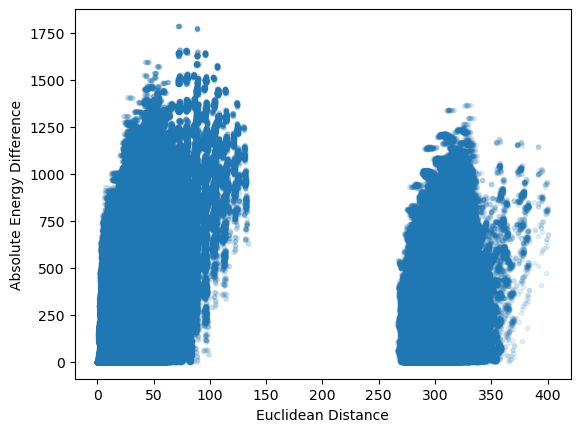

In [6]:
# a)
def load_and_transform_data(X_matrix, T_vector):
    """ Transform each Coulomb matrix into a vector of its eigenvalues sorted by absolute value. """
    X_transformed = np.array([np.sort(np.abs(np.linalg.eigh(matrix)[0]))[::-1] for matrix in X_matrix])
    return X_transformed, T_vector


def plot_distances_vs_energy_differences(X, y):
    """ Compute and plot all pairwise Euclidean distances vs. absolute energy differences. """
    distances = distance_matrix(X, X)
    energy_differences = np.abs(y[:, None] - y)

    plt.scatter(distances.ravel(), energy_differences.ravel(), alpha=0.05, marker='.')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Absolute Energy Difference')
    plt.show()

# a)
X, y = load_and_transform_data(X_matrix, T_vector)
plot_distances_vs_energy_differences(X, y)

In [7]:
def shuffle_and_split(X, y):
    np.random.seed(0)  # for reproducibility
    train_size = 5000
    test_size = 2165
    # could also use indices = np.random.permutation(len(y))
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    test_indices = indices[-test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# b)
X_train, X_test, y_train, y_test = shuffle_and_split(X, y)

In [8]:
len(X_train), len(X_test)

(5000, 2165)

In [13]:
def estimate_parameters(X, y):

    X_subset = X[:100]
    labels_subset = X[:100]

    def _calculate_sigma_candidates(X, quantiles):
        distances = distance_matrix(X, X)
        sigma_candidates = np.quantile(distances, quantiles)
        return sigma_candidates

    # Prepare parameters for cross-validation
    sigma_candidates = _calculate_sigma_candidates(X_subset, [0.25, 0.5, 0.75])

    # Define the range and number of points
    start = -7  # 10**-7
    stop = 2    # 10**2
    num_points = 10  # number of points

    # Generate logarithmically spaced values between 10^-7 and 10^2
    C_candidates = np.logspace(start, stop, num=num_points, endpoint=True)

    parameters = {
        'kernel': ['gaussian'],
        'kernelparameter': sigma_candidates,
        'regularization': C_candidates
    }

    # Define method to be used within the cv function
    method = krr

    # Perform cross-validation
    best_model = cv(X, y, method, parameters, nfolds=5, nrepetitions=1)

    # Results
    print("Best Parameters:", best_model.kernelparameter, best_model.regularization)
    print("Cross-validated Loss:", best_model.cvloss)

    return best_model

best_model = estimate_parameters(X_train, y_train)

In [ ]:
def load_mat_data():
    data_path = r'data\qm7.mat'
    data = scipy.io.loadmat(data_path)

    # Assuming the structure contains 'X' as the Coulomb matrices and 'T' as the target energies
    X = data['X']
    y = data['T'].flatten()  # Flatten if T is a 2D array with a single dimension size of 1

    print("Coulomb Matrices Shape:", X.shape)
    print("Target Energies Shape:", y.shape)
    return X, y

def load_data_from_directory(directory_path):
    data = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.dat'):
            file_path = os.path.join(directory_path, filename)
            try:
                # Modify delimiter if necessary based on the actual format of the .dat files
                loaded_data = np.loadtxt(file_path, delimiter=' ')
                data[filename] = loaded_data
                print(f"Loaded {filename} successfully.")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

    return data

# Use absolute paths for clarity and reliability
directory_path = r'data'
X_matrix, T_vector = load_mat_data()
# all_data = load_data_from_directory(directory_path)

Coulomb Matrices Shape: (7165, 23, 23)
Target Energies Shape: (7165,)


Training Size: 100, MAE: 65.1753
Training Size: 357, MAE: 28.2016
Training Size: 615, MAE: 21.7753
Training Size: 873, MAE: 19.2996
Training Size: 1131, MAE: 18.9100
Training Size: 1389, MAE: 16.4667
Training Size: 1647, MAE: 15.4743
Training Size: 1905, MAE: 13.2306
Training Size: 2163, MAE: 12.4290
Training Size: 2421, MAE: 12.3056
Training Size: 2678, MAE: 11.8648
Training Size: 2936, MAE: 11.9114
Training Size: 3194, MAE: 11.6521
Training Size: 3452, MAE: 11.4386
Training Size: 3710, MAE: 11.5478
Training Size: 3968, MAE: 11.3057
Training Size: 4226, MAE: 10.9966
Training Size: 4484, MAE: 10.9321
Training Size: 4742, MAE: 10.8032
Training Size: 5000, MAE: 10.8164


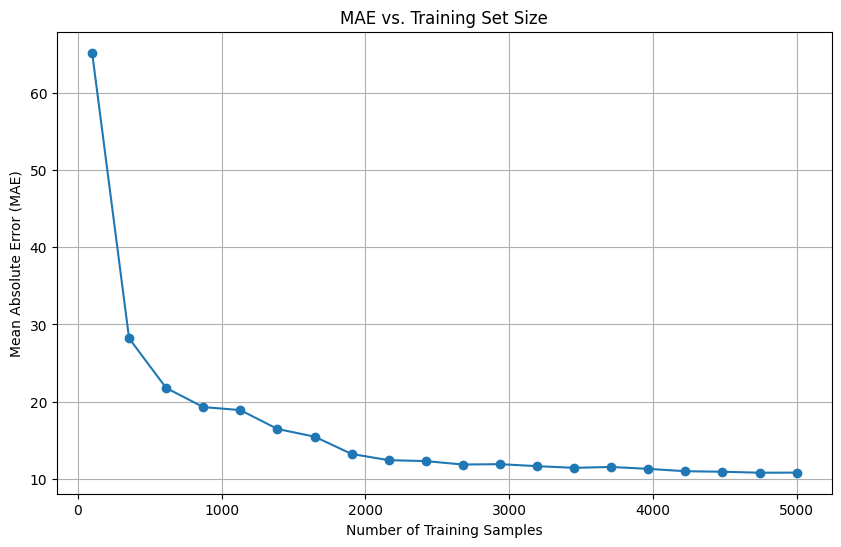

In [ ]:
def evaluate_performance(X_train, y_train, X_test, y_test, kernelparameter, regularization, sizes):
    maes = []
    sample_sizes = np.linspace(100, min(len(X_train), 5000), num=sizes, dtype=int)
    
    for size in sample_sizes:
        # Select a subset of training data
        X_subset = X_train[:size]
        y_subset = y_train[:size]
        
        # Initialize the model with the best parameters
        model = krr(
            kernel='gaussian', 
            kernelparameter=kernelparameter, 
            regularization=regularization
        )
        model.fit(X_subset, y_subset)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate MAE
        mae = np.mean(np.abs(y_pred - y_test))
        maes.append(mae)
        print(f"Training Size: {size}, MAE: {mae:.4f}")

    return sample_sizes, maes

# d)
sizes, maes = evaluate_performance(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    best_model.kernelparameter, 
    best_model.regularization, 
    sizes=20
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sizes, maes, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Training Set Size')
plt.grid(True)
plt.show()


Running model :  0
Running model :  1
Running model :  2


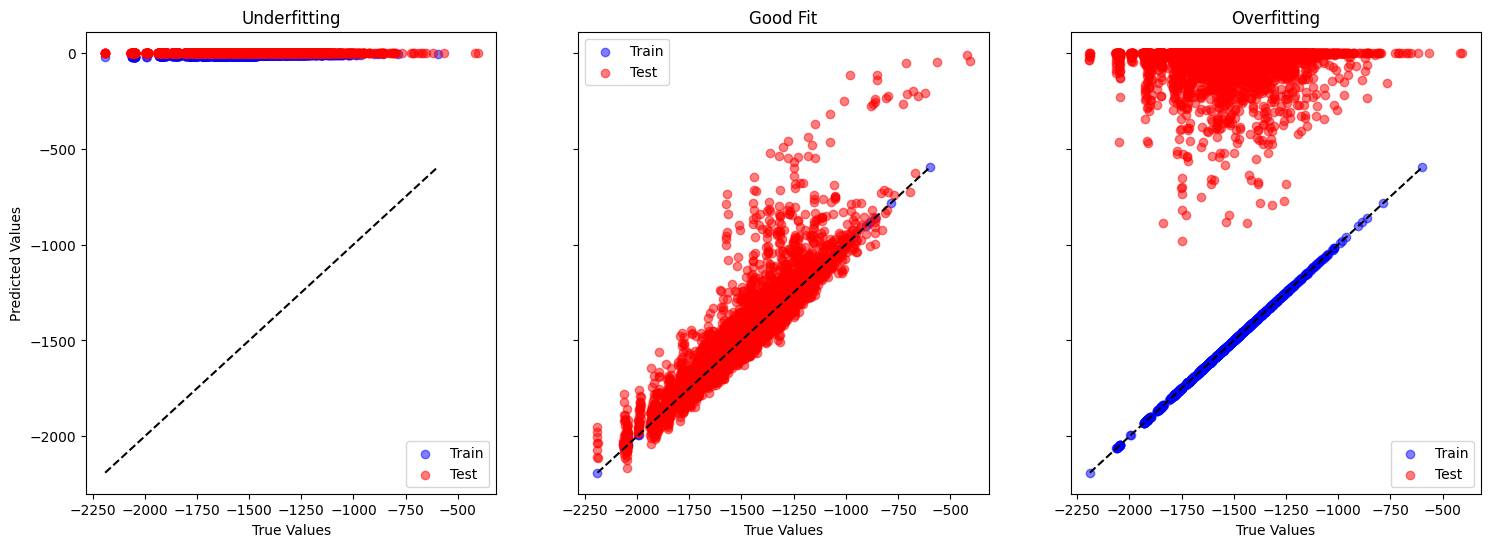

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume the `krr` class is defined as provided in earlier discussions

def plot_fitting_scenarios(X_train, y_train, X_test, y_test, params):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    titles = ['Underfitting', 'Good Fit', 'Overfitting']
    
    for i, param in enumerate(params):
        print("Running model : ", i)
        # Initialize and train the model
        model = krr(kernel='gaussian', kernelparameter=param['kernelparameter'], regularization=param['regularization'])
        model.fit(X_train, y_train)  # Use only 1000 samples for training
        
        # Predict for both train and test sets
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Plotting
        axes[i].scatter(y_train[:1000], y_train_pred, color='blue', alpha=0.5, label='Train')
        axes[i].scatter(y_test, y_test_pred, color='red', alpha=0.5, label='Test')
        axes[i].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')  # Ideal line y=x
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('True Values')
        if i == 0:
            axes[i].set_ylabel('Predicted Values')
        axes[i].legend()
    
    plt.show()

# Parameters setup
params = [
    {'kernelparameter': 0.1, 'regularization': 100},  # Underfitting: high regularization, small kernel width
    {'kernelparameter': 23.660309182176555, 'regularization': 1e-05}, # Good Fit: moderate settings
    {'kernelparameter': 5, 'regularization': 0.0001}  # Overfitting: low regularization, large kernel width
]

# Assuming X and y are already defined and shuffled
np.random.seed(42)
indices = np.random.permutation(len(T_vector))
X_shuffled = X_matrix[indices]
y_shuffled = T_vector[indices]

# Create a train/test split
train_size = 1000  # Train size larger than 1000 for more general testing later if needed
X_train, X_test = X_shuffled[:train_size], X_shuffled[train_size:]
y_train, y_test = y_shuffled[:train_size], y_shuffled[train_size:]

# Plot the fitting scenarios
plot_fitting_scenarios(X_train, y_train, X_test, y_test, params)
